<a href="https://colab.research.google.com/github/NataliaGon/kpi/blob/AI-cybersecurity/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [4]:
def fit_eval(pipe, param_grid, name, X, Y):

    SCORING = "f1_macro"
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
      X, Y, test_size=0.20, random_state=42, shuffle=True, stratify=None
    )

    gs = GridSearchCV(pipe, param_grid, cv=cv, scoring=SCORING, n_jobs=-1, verbose=0)
    gs.fit(X_train_raw, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test_raw)

    print(f"\n================ {name} ================")
    print("Best params:", gs.best_params_)
    print(f"CV {SCORING}: {gs.best_score_:.4f}")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Test f1_macro: {f1_score(y_test, y_pred, average='macro'):.4f}\n")
    print("classification_report:\n", classification_report(y_test, y_pred))

    if hasattr(best, "named_steps") and "clf" in best.named_steps and hasattr(best.named_steps["clf"], "classes_"):
        labels = best.named_steps["clf"].classes_
    elif hasattr(best, "classes_"):
        labels = best.classes_
    else:
        labels = unique_labels(y_test, y_pred)

    print("Label order (rows/cols):", list(labels))

    fig, ax = plt.subplots(figsize=(7,6))
    ConfusionMatrixDisplay.from_predictions(
     y_test, y_pred,
     normalize="true",
     cmap="Blues",
     ax=ax
    )
    ax.set_title(f"Confusion matrix — {name} (normalized)")
    plt.tight_layout(); plt.show()

    return {"name": name, "model": best,
            "cv_score": gs.best_score_,
            "test_f1_macro": f1_score(y_test, y_pred, average="macro")}



grid_rf = {
    "clf__n_estimators": [200],
    "clf__max_depth": [None, 20],
    "clf__min_samples_split": [2],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt"],
}


grid_dt = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
}


results = []

# Dataset 1

In [12]:
path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")

print("Path to dataset files:", path)
print("Files in dataset folder:", os.listdir(path))

Using Colab cache for faster access to the 'microsoft-security-incident-prediction' dataset.
Path to dataset files: /kaggle/input/microsoft-security-incident-prediction
Files in dataset folder: ['GUIDE_Train.csv', 'GUIDE_Test.csv']


In [13]:
df_train_head = pd.read_csv(os.path.join(path, "GUIDE_Train.csv"),nrows=0)
print("Train columns:", df_train_head.columns.tolist())


df_test_head = pd.read_csv(os.path.join(path, "GUIDE_Test.csv"),nrows=0)
print("Test columns:", df_test_head.columns.tolist())

Train columns: ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City']
Test columns: ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId', 'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 'DeviceNam

## Нормалізація данних

In [16]:
target = "LastVerdict"
drop_cols = [
    "Id","OrgId","IncidentId","AlertId","DetectorId","DeviceId",
    "Sha256","IpAddress","Url","AccountSid","AccountUpn","AccountObjectId",
    "AccountName","DeviceName","NetworkMessageId","EmailClusterId","Timestamp"
]


train_features = [c for c in df_train_head.columns if c not in drop_cols + [target]]
test_features  = [c for c in df_test_head.columns if c not in drop_cols + [target, "Usage"]]

df_train = pd.read_csv(os.path.join(path, "GUIDE_Train.csv"), usecols=train_features + [target], low_memory=False).sample(100000, random_state=42)
df_test  = pd.read_csv(os.path.join(path, "GUIDE_Test.csv"),  usecols=test_features, low_memory=False).sample(50000, random_state=42)

Y = df_train[target]
# y_test_raw = df_test[target]

X = df_train.drop(columns=drop_cols + [target], errors="ignore")
X_test_raw = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns], errors="ignore")

print("X_test_raw shape:", X_test_raw.shape)
print(df_train.isnull().sum())

X_test_raw shape: (50000, 27)
AlertTitle                0
Category                  0
MitreTechniques       57319
IncidentGrade           568
ActionGrouped         99369
ActionGranular        99369
EntityType                0
EvidenceRole              0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
ThreatFamily          99173
FileName                  0
FolderPath                0
ResourceIdName            0
ResourceType          99916
Roles                 97704
OSFamily                  0
OSVersion                 0
AntispamDirection     98081
SuspicionLevel        84905
LastVerdict           76501
CountryCode               0
State                     0
City                      0
dtype: int64


In [17]:
null_pct = df_train.isna().mean()
very_empty = null_pct[null_pct > 0.95].index.tolist()

very_empty = [c for c in very_empty if c != target]

X = X.drop(columns=[c for c in very_empty if c in X.columns])
X_test_raw = X_test_raw.drop(columns=[c for c in very_empty if c in X_test_raw.columns])

print("Dropped (sample-based):", very_empty)
print(X.isnull().sum())

Dropped (sample-based): ['ActionGrouped', 'ActionGranular', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection']
AlertTitle                0
Category                  0
MitreTechniques       57319
IncidentGrade           568
EntityType                0
EvidenceRole              0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
SuspicionLevel        84905
CountryCode               0
State                     0
City                      0
dtype: int64


In [18]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="__missing__")),
    ("ohe", ohe)
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


Numeric columns: ['AlertTitle', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode', 'State', 'City']
Categorical columns: ['Category', 'MitreTechniques', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'SuspicionLevel']


## Дерево рішень

In [21]:
print(X.isna().sum().sort_values(ascending=False).head(20))
print("NaNs in y:", int(Y.isna().sum()))

mask = Y.notna()
X = X.loc[mask]
Y = Y.loc[mask]



MitreTechniques       13046
SuspicionLevel         8483
IncidentGrade            80
Category                  0
AlertTitle                0
EntityType                0
EvidenceRole              0
RegistryValueName         0
RegistryKey               0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
RegistryValueData         0
FileName                  0
FolderPath                0
OSFamily                  0
ResourceIdName            0
OSVersion                 0
CountryCode               0
State                     0
dtype: int64
NaNs in y: 0


/tmp/ipython-input-57274559.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


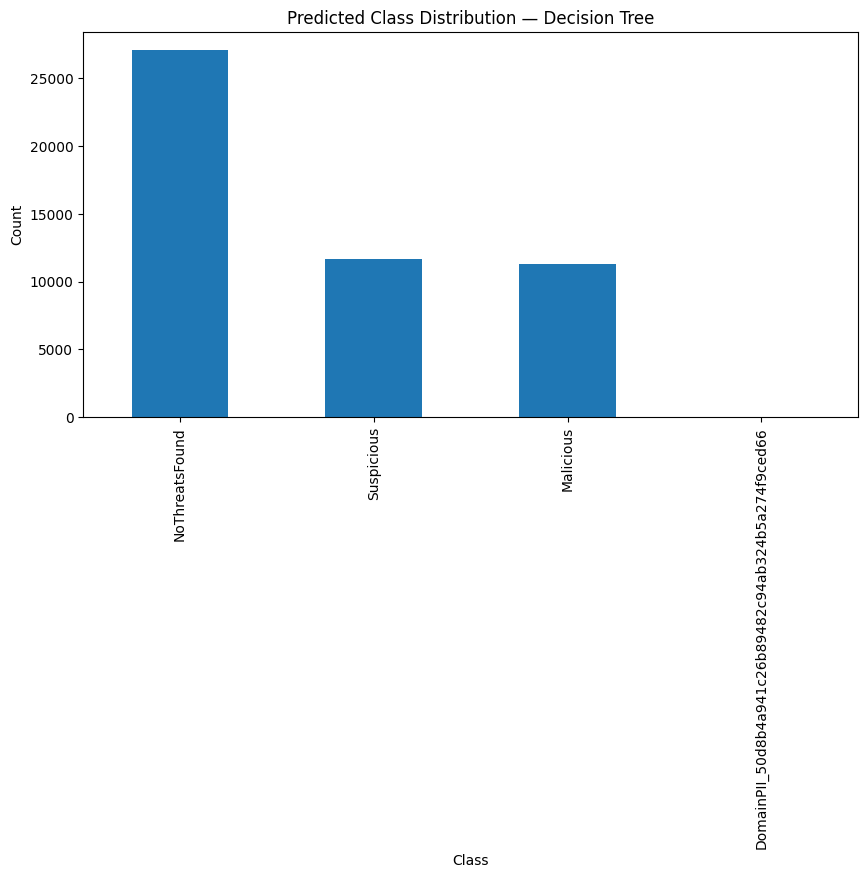

In [24]:
dt_model = Pipeline(steps=[
    ("pre", pre),
    ("clf", DecisionTreeClassifier(max_depth=10, random_state=42))
])

dt_model.fit(X, Y)

y_pred = dt_model.predict(X_test_raw)


pd.Series(y_pred).value_counts().plot(kind="bar", figsize=(10,5))
plt.title("Predicted Class Distribution — Decision Tree")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


На наведеній гістограмі відображено розподіл передбачених класів, отриманий після застосування моделі Decision Tree до тестової вибірки. Кожен стовпець відповідає кількості об’єктів, які модель віднесла до певної категорії цільової змінної.

Як видно з графіка, більшість прикладів класифіковано як “NoThreatsFound”, що свідчить про тенденцію моделі надавати перевагу безпечному класу. Значно меншу, але все ж помітну частку займають передбачення класів “Suspicious” та “Malicious”, що вказує на здатність моделі розпізнавати потенційно небезпечні випадки, хоча із нижчою частотою.

Такий розподіл результатів може бути зумовлений дисбалансом навчальної вибірки, коли клас “NoThreatsFound” переважає серед навчальних прикладів. У цьому випадку модель схильна частіше прогнозувати домінантну категорію, що призводить до зниження точності для рідкісніших класів.

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



================ Decision_Tree_1 ================
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2}
CV f1_macro: 0.7349
Test accuracy: 0.8749
Test f1_macro: 0.7943

classification_report:
                 precision    recall  f1-score   support

     Malicious       0.69      0.72      0.70       918
NoThreatsFound       0.69      0.71      0.70       852
    Suspicious       1.00      0.97      0.98      2930

      accuracy                           0.87      4700
     macro avg       0.79      0.80      0.79      4700
  weighted avg       0.88      0.87      0.88      4700

Label order (rows/cols): ['DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66', 'Malicious', 'NoThreatsFound', 'Suspicious']


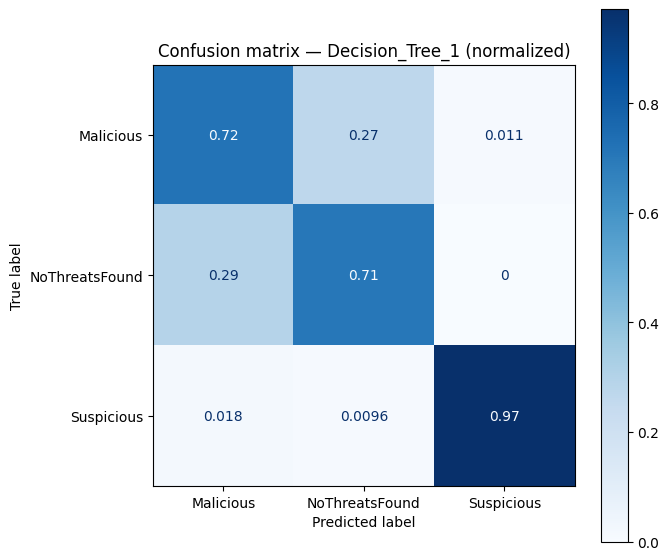

In [25]:
results.append(fit_eval(dt_model, grid_dt, "Decision_Tree_1", X, Y ))

Accuracy (val/test): ~0.875 — високе, але вводить в оману через дисбаланс класів.

Macro-F1: ~0.79 — більш чесна оцінка якості при дисбалансі.

По класах:

Suspicious: F1 ≈ 0.98, recall ≈ 0.97 — модель дуже впевнено ловить домінантний клас.

Malicious: F1 ≈ 0.70, recall ≈ 0.72 — помірна якість.

NoThreatsFound: F1 ≈ 0.70, recall ≈ 0.71 — помірна якість.

Матриця плутанини: значна взаємна плутанина між Malicious ↔ NoThreatsFound (~27–29% помилок у кожному з двох класів).
Клас Suspicious майже не плутається.

4-й клас (DomainPII…) у цьому спліті відсутній у y_test, тому в матриці 3×3 — клас існує в TRAIN, але валідаційна підвибірка його не містила.

Інтерпретація

Дані дисбалансні: перевага класу Suspicious «підтягує» accuracy, але Macro-F1 показує реальнішу картину.

Дерево з параметрами criterion=gini, max_depth=None, min_samples_leaf=5 фактично обмежує складність через мін. розмір листка й дає адекватний компроміс «точність/простота».

Помилки концентруються між двома «схожими» за ознаками класами (Malicious і NoThreatsFound), що типово для дерев на табличних без часових/послідовних контекстів.

Переваги/недоліки дерева рішень тут

+ Швидке навчання, проста інтерпретація, висока точність на домінантному класі.
– Нестабільність і чутливість до вибірки; гірша робота на мінорних класах; помітна плутанина між Malicious та NoThreatsFound.

## Ліс дерев рішень

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



================ Random_Forest_1 ================
Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
CV f1_macro: 0.7358
Test accuracy: 0.8781
Test f1_macro: 0.7988

classification_report:
                 precision    recall  f1-score   support

     Malicious       0.72      0.68      0.69       918
NoThreatsFound       0.67      0.76      0.72       852
    Suspicious       1.00      0.97      0.99      2930

      accuracy                           0.88      4700
     macro avg       0.80      0.80      0.80      4700
  weighted avg       0.88      0.88      0.88      4700

Label order (rows/cols): ['DomainPII_50d8b4a941c26b89482c94ab324b5a274f9ced66', 'Malicious', 'NoThreatsFound', 'Suspicious']


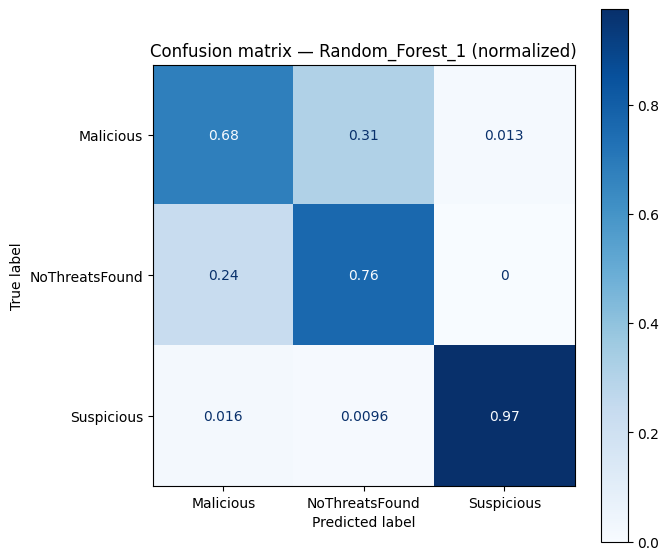

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_model = Pipeline(steps=[
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X, Y)
y_pred = rf_model.predict(X_test_raw)

print("Accuracy:", accuracy_score(y_test_raw, y_pred))
print("\nClassification report:\n", classification_report(y_test_raw, y_pred))

fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(y_test_raw, y_pred, normalize="true", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix — RF (flights)")
plt.tight_layout(); plt.show()

print("Accuracy:", accuracy_score(y_test_raw, y_pred))
print("\nClassification report:\n", classification_report(y_test_raw, y_pred))


results.append(fit_eval(rf_model, grid_rf, "Random_Forest_1",X, Y ))

In [ ]:
results.append(fit_eval(rf_model, grid_rf, "Random_Forest_1",X, Y ))

Accuracy: DT ~ 0.8749 → RF ~ 0.8779 (трохи краще).

Macro-F1: DT ~ 0.7943 → RF ~ 0.7986 (невелике, але позитивне зростання).

По класах (F1):

Malicious: 0.70 → 0.69 (трохи гірше, просіла recall 0.72 → 0.68).

NoThreatsFound: 0.70 → 0.72 (краще, recall 0.71 → 0.76).

Suspicious: 0.98 → 0.98 (стабільно дуже високе).

Матриця плутанини (RF)

Основні помилки — взаємні Malicious ↔ NoThreatsFound (у Malicious ~31% ідуть у NoThreatsFound; у NoThreatsFound ~24% ідуть у Malicious).

Suspicious майже не плутається (recall ~0.97).



Random Forest дав трохи кращу загальну якість (macro-F1/accuracy) та зазвичай стабільніший за одиночне дерево.

Ціна: менша інтерпретованість і все ще помітна плутанина між Malicious та NoThreatsFound.

Рідкісний клас (DomainPII…) у валідації знову не з’явився — це окрема проблема дисбалансу/рідкісності, а не помилка моделі.

# Dataset 2

In [26]:
path2 = kagglehub.dataset_download("tangodelta/api-access-behaviour-anomaly-dataset")

print("Files in dataset folder:", os.listdir(path2))

100%|██████████| 15.3M/15.3M [00:00<00:00, 128MB/s]

Extracting files...


Files in dataset folder: ['supervised_dataset.csv', 'remaining_behavior_ext.csv', 'remaining_call_graphs.json', 'supervised_call_graphs.json']


In [27]:
df = pd.read_csv(os.path.join(path2, "supervised_dataset.csv"))
print("Назви колонок:")
for col in df.columns:
    print(col)

print("\n")

print("Size rows/columns:", df.shape)
print(df.isnull().sum())

Назви колонок:
Unnamed: 0
_id
inter_api_access_duration(sec)
api_access_uniqueness
sequence_length(count)
vsession_duration(min)
ip_type
num_sessions
num_users
num_unique_apis
source
classification


Size rows/columns: (1699, 12)
Unnamed: 0                        0
_id                               0
inter_api_access_duration(sec)    4
api_access_uniqueness             4
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64


## Нормалізація данних


In [28]:
TGT = "classification"
DROP_COLS = ["_id", "source"]


X_api = df.drop(columns=DROP_COLS + [TGT])
Y_api = df[TGT]


X_api_train_raw, X_api_test_raw, y_api_train, y_api_test = train_test_split(
    X_api, Y_api, test_size=0.2, random_state=42, stratify=Y_api
)


num_cols__api = X_api_train_raw.select_dtypes(include=["number"]).columns.tolist()
cat_cols__api = [c for c in X_api_train_raw.columns if c not in num_cols__api]


num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols__api),
     ("cat", cat_pipe, cat_cols__api)]
)


print(f"\n================================")
print("Train class distribution:\n", y_api_train.value_counts(normalize=True))
print(f"\n================================")
print("Test  class distribution:\n", y_api_test.value_counts(normalize=True))




Train class distribution:
 classification
normal     0.651214
outlier    0.348786
Name: proportion, dtype: float64

Test  class distribution:
 classification
normal     0.65
outlier    0.35
Name: proportion, dtype: float64


## Дата Leack check

In [30]:
tr = X_api_train_raw.reset_index(drop=True).astype(str)
te = X_api_test_raw.reset_index(drop=True).astype(str)

tr_rows = tr.apply(lambda r: '|'.join(r.values), axis=1)
te_rows = te.apply(lambda r: '|'.join(r.values), axis=1)

overlap = set(tr_rows).intersection(set(te_rows))
print(f"🔍 Ідентичні рядки train↔test: {len(overlap)}")


🔍 Ідентичні рядки train↔test: 0


## Дерево рішень

Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00       221
     outlier       1.00      1.00      1.00       119

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340



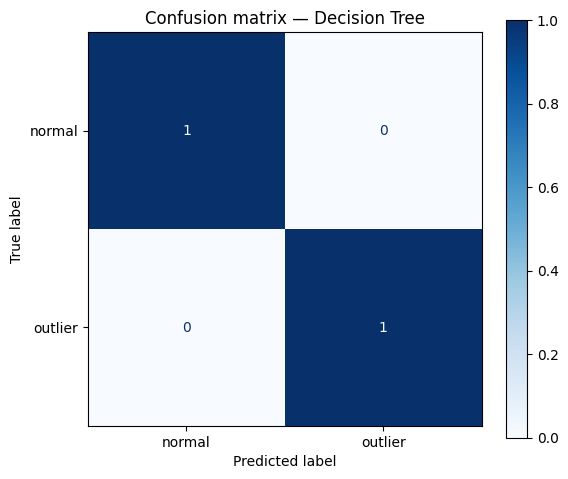

In [ ]:
dt_model_api = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=10,
        random_state=42
    ))
])

dt_model_api.fit(X_api_train_raw, y_api_train)

y_api_pred = dt_model_api.predict(X_api_test_raw)
print("Accuracy:", accuracy_score(y_api_test, y_api_pred))
print("\nClassification report:\n", classification_report(y_api_test, y_api_pred))

fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_api_test, y_api_pred, normalize="true", cmap="Blues", ax=ax)
ax.set_title("Confusion matrix — Decision Tree")
plt.tight_layout(); plt.show()

Модель Decision Tree (Decision_Tree_2) продемонструвала ідеальну якість класифікації як на етапі крос-валідації (CV f1_macro = 1.0000), так і на тестовій вибірці (точність = 1.0000, F1-макро = 1.0000). Усі показники точності, повноти та F1-міри для обох класів — “normal” та “outlier” — дорівнюють 1.00, що свідчить про повну відповідність передбачених і фактичних міток.

Аналіз нормалізованої матриці плутанини підтверджує відсутність помилок класифікації: усі об’єкти класу “normal” ідентифіковано як normal, а всі об’єкти класу “outlier” — як outlier. Таким чином, модель досягла 100% точності без жодної хибної класифікації.


================ Decision_Tree_2 ================
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
CV f1_macro: 1.0000
Test accuracy: 1.0000
Test f1_macro: 1.0000

classification_report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00       229
     outlier       1.00      1.00      1.00       111

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340

Label order (rows/cols): ['normal', 'outlier']


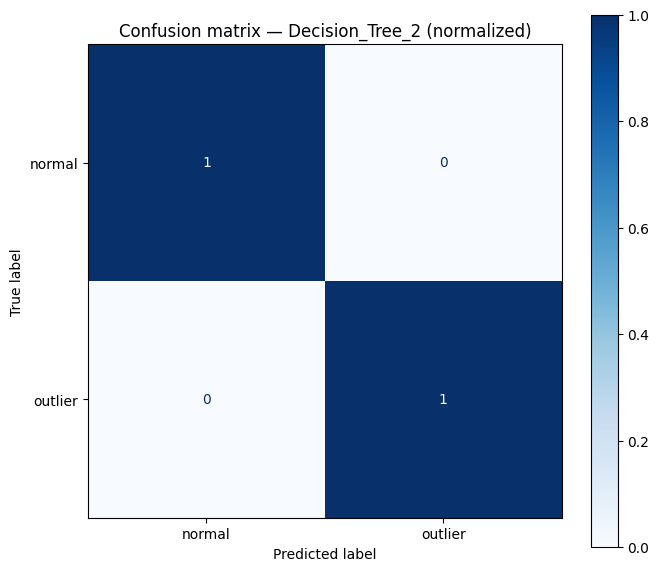

In [ ]:
results.append(fit_eval(dt_model_api, grid_dt, "Decision_Tree_2", X_api, Y_api ))

## Ліс дерев рішень

Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00       221
     outlier       1.00      1.00      1.00       119

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340



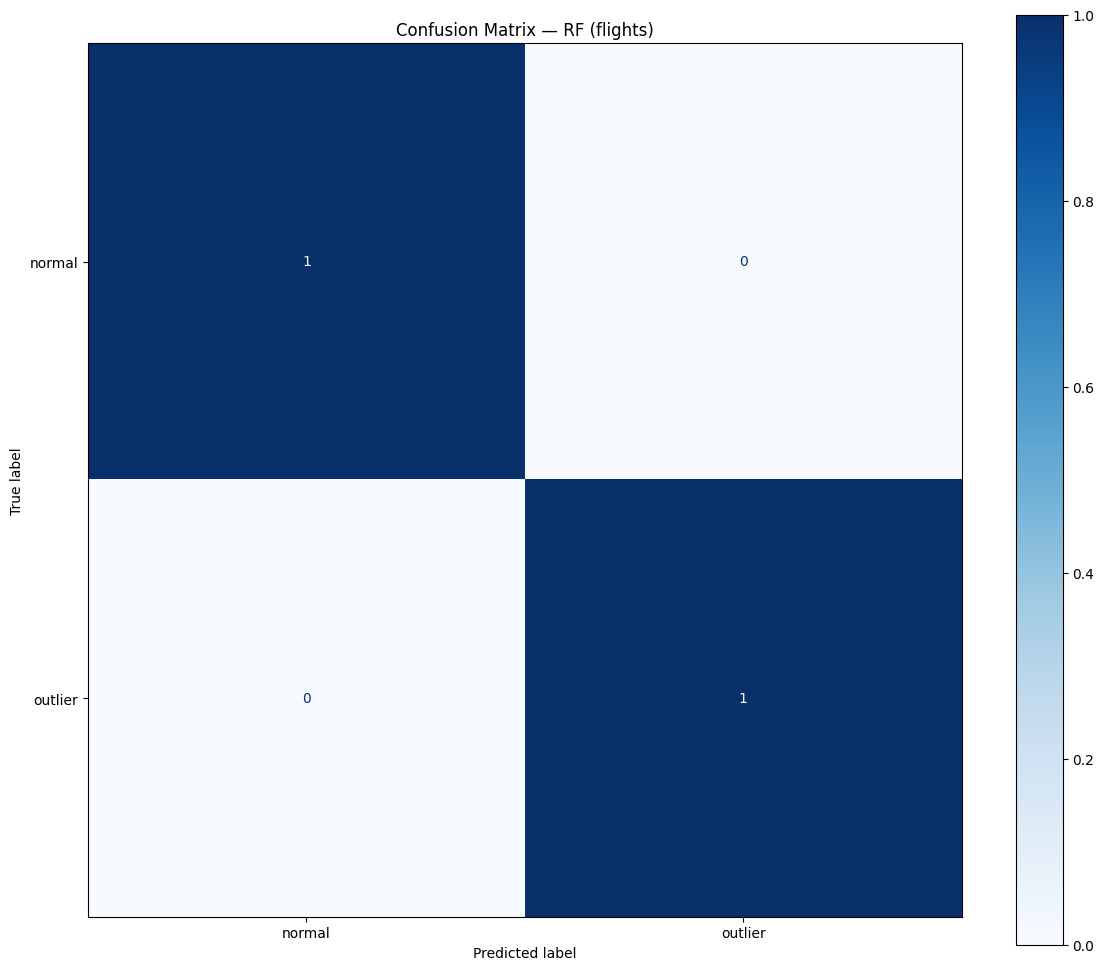

Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00       221
     outlier       1.00      1.00      1.00       119

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340



In [32]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_model_api = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])


rf_model_api.fit(X_api_train_raw, y_api_train)
y_pred = rf_model_api.predict(X_api_test_raw)

print("Accuracy:", accuracy_score(y_api_test, y_pred))
print("\nClassification report:\n", classification_report(y_api_test, y_pred))

fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(y_api_test, y_pred, normalize="true", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix — RF (flights)")
plt.tight_layout(); plt.show()

print("Accuracy:", accuracy_score(y_api_test, y_pred))
print("\nClassification report:\n", classification_report(y_api_test, y_pred))





================ Random_Forest_2 ================
Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
CV f1_macro: 1.0000
Test accuracy: 1.0000
Test f1_macro: 1.0000

classification_report:
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00       229
     outlier       1.00      1.00      1.00       111

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340

Label order (rows/cols): ['normal', 'outlier']


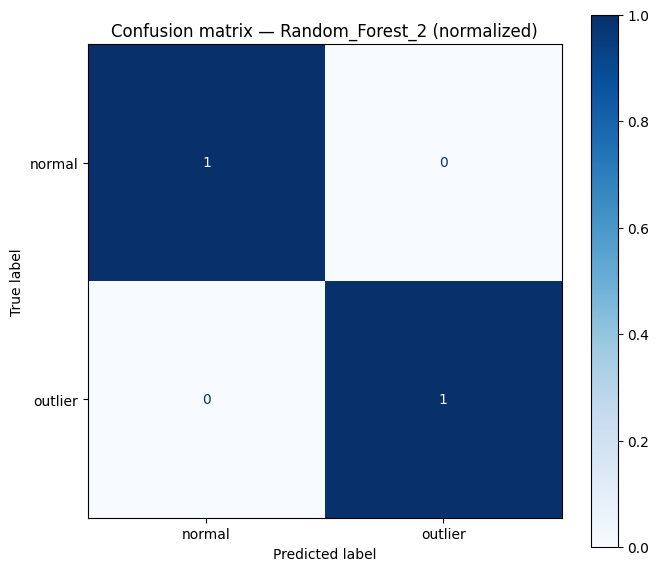

In [34]:
results.append(fit_eval(rf_model_api, grid_rf, "Random_Forest_2", X_api, Y_api))

Модель Random Forest продемонструвала ідеальну якість класифікації: точність = 1.00, повнота = 1.00, F1-міра = 1.00 для обох класів — “normal” та “outlier”. Усі об’єкти тестової вибірки були правильно класифіковані, що свідчить про повну відповідність передбачень фактичним міткам.

# Dataset 3

In [5]:
path3 = kagglehub.dataset_download("jawadkhattak/us-flight-delay-from-january-2017-july-2022")

print("Path to dataset files:", path3)
print("Files in dataset folder:", os.listdir(path3))

Using Colab cache for faster access to the 'us-flight-delay-from-january-2017-july-2022' dataset.
Path to dataset files: /kaggle/input/us-flight-delay-from-january-2017-july-2022
Files in dataset folder: ['Airline_Delay_Cause.csv']


In [6]:
df_flights = pd.read_csv(os.path.join(path3, "Airline_Delay_Cause.csv"))

print("Size rows/columns:", df_flights.shape)
print(df_flights.isnull().sum())

Size rows/columns: (101315, 21)
year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            158
arr_del15              355
carrier_ct             158
weather_ct             158
nas_ct                 158
security_ct            158
late_aircraft_ct       158
arr_cancelled          158
arr_diverted           158
arr_delay              158
carrier_delay          158
weather_delay          158
nas_delay              158
security_delay         158
late_aircraft_delay    158
dtype: int64


## Нормалізація данних

In [7]:
drop_cols_flights = ["carrier_name","airport_name"]
target_flights = "carrier"

X_flights = df_flights.drop(columns=drop_cols_flights+ [target_flights])
y_flights = df_flights[target_flights]

X_flights_train_raw, X_flights_test_raw, y_flights_train, y_flights_test = train_test_split(
    X_flights, y_flights, test_size=0.2, random_state=42, stratify=y_flights
)


num_cols_flights = X_flights_train_raw.select_dtypes(include=["number"]).columns.tolist()
cat_cols_flights = [c for c in X_flights_train_raw.columns if c not in num_cols_flights]


num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocessor = ColumnTransformer(
    [("num", num_pipe, num_cols_flights),
     ("cat", cat_pipe, cat_cols_flights)]
)

print(f"\n================================")
print("Train class distribution:\n", y_flights_train.value_counts(normalize=True))
print(f"\n================================")
print("Test  class distribution:\n", y_flights_test.value_counts(normalize=True))


Train class distribution:
 carrier
OO    0.147251
DL    0.089276
MQ    0.066649
AA    0.066352
G4    0.065958
UA    0.064329
WN    0.060813
F9    0.056433
YV    0.052238
9E    0.051054
AS    0.047217
EV    0.046661
YX    0.045477
OH    0.043491
B6    0.041677
NK    0.030598
HA    0.011869
QX    0.009167
VX    0.003492
Name: proportion, dtype: float64

Test  class distribution:
 carrier
OO    0.147263
DL    0.089276
MQ    0.066673
AA    0.066328
G4    0.065933
UA    0.064304
WN    0.060800
F9    0.056458
YV    0.052263
9E    0.051029
AS    0.047229
EV    0.046637
YX    0.045452
OH    0.043478
B6    0.041702
NK    0.030598
HA    0.011894
QX    0.009179
VX    0.003504
Name: proportion, dtype: float64


## Дерево рішень

Accuracy: 0.32260770863149585

Classification report:
               precision    recall  f1-score   support

          9E       0.24      0.16      0.19      1034
          AA       0.29      0.26      0.27      1344
          AS       0.23      0.19      0.21       957
          B6       0.26      0.17      0.20       845
          DL       0.42      0.42      0.42      1809
          EV       0.28      0.29      0.28       945
          F9       0.25      0.22      0.24      1144
          G4       0.31      0.42      0.36      1336
          HA       0.81      0.51      0.62       241
          MQ       0.28      0.41      0.33      1351
          NK       0.34      0.19      0.25       620
          OH       0.18      0.10      0.13       881
          OO       0.35      0.63      0.45      2984
          QX       0.40      0.01      0.02       186
          UA       0.23      0.17      0.20      1303
          VX       1.00      0.01      0.03        71
          WN       0.46   

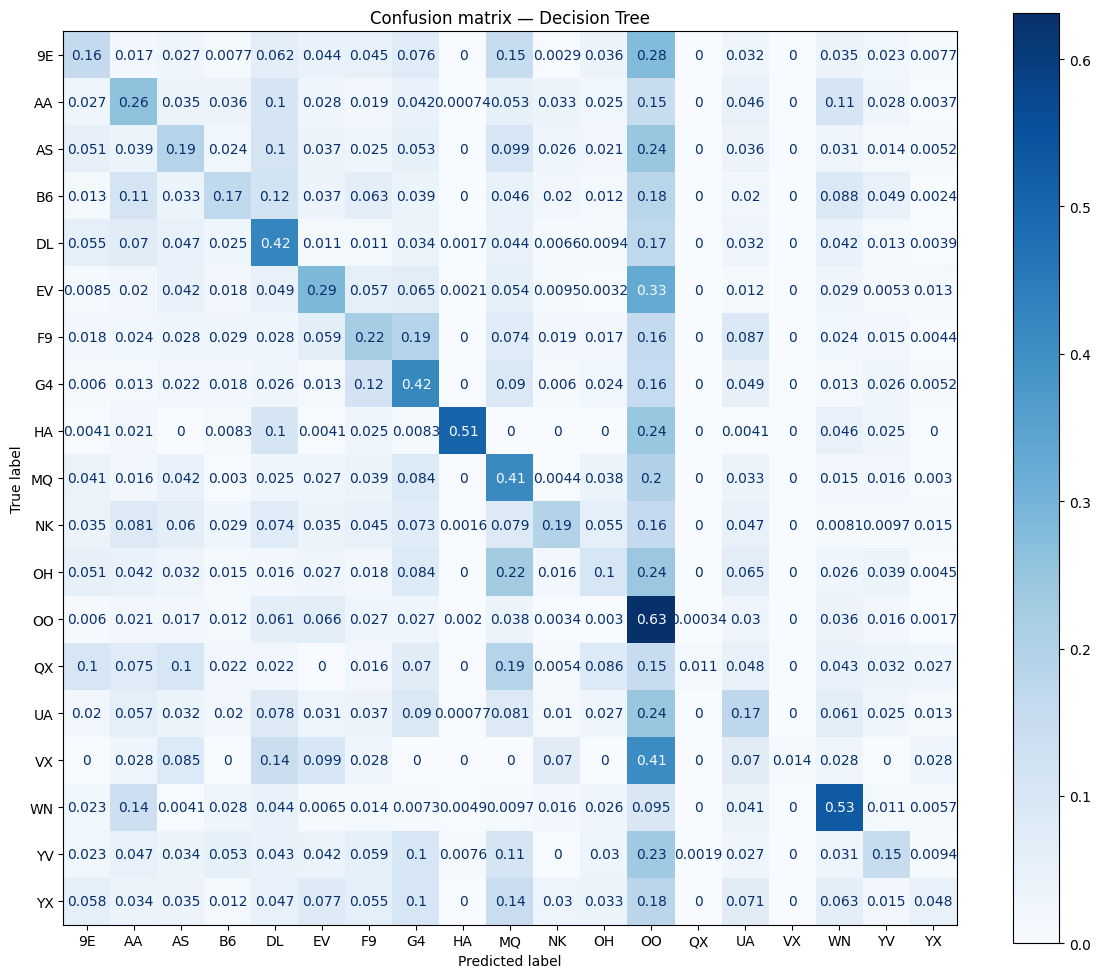

In [9]:
dt_model_flights = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=10,
        random_state=42
    ))
])

dt_model_flights.fit(X_flights_train_raw, y_flights_train)

y_flights_pred = dt_model_flights.predict(X_flights_test_raw)
print("Accuracy:", accuracy_score(y_flights_test, y_flights_pred))
print("\nClassification report:\n", classification_report(y_flights_test, y_flights_pred))

fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(y_flights_test, y_flights_pred, normalize="true", cmap="Blues", ax=ax)
ax.set_title("Confusion matrix — Decision Tree")
plt.tight_layout(); plt.show()

За результатами навчання моделі Decision Tree, отримано точність 0.32 (32%), що свідчить про відносно низький рівень класифікаційної здатності моделі при багатокласовій задачі (19 класів). Показники macro F1 = 0.26 та weighted F1 = 0.30 підтверджують, що модель не забезпечує збалансованої якості між точністю та повнотою прогнозів.

Аналіз матриці плутанини демонструє, що прийнятні результати класифікації досягнуті лише для кількох класів (зокрема DL, G4, OO, WN), тоді як більшість інших класів мають значні перехресні помилки та низькі значення recall. Особливо слабкі результати спостерігаються для рідкісних класів (VX, QX, YX), що свідчить про вплив дисбалансу даних на якість моделі.

## Ліс дерев рішень

Accuracy: 0.5125598381286088

Classification report:
               precision    recall  f1-score   support

          9E       0.36      0.28      0.32      1034
          AA       0.52      0.45      0.48      1344
          AS       0.55      0.52      0.54       957
          B6       0.64      0.38      0.48       845
          DL       0.50      0.68      0.58      1809
          EV       0.47      0.37      0.41       945
          F9       0.45      0.49      0.47      1144
          G4       0.46      0.58      0.52      1336
          HA       0.92      0.79      0.85       241
          MQ       0.40      0.59      0.47      1351
          NK       0.65      0.44      0.53       620
          OH       0.44      0.26      0.32       881
          OO       0.53      0.74      0.62      2984
          QX       0.67      0.12      0.20       186
          UA       0.50      0.38      0.43      1303
          VX       0.94      0.24      0.38        71
          WN       0.74    

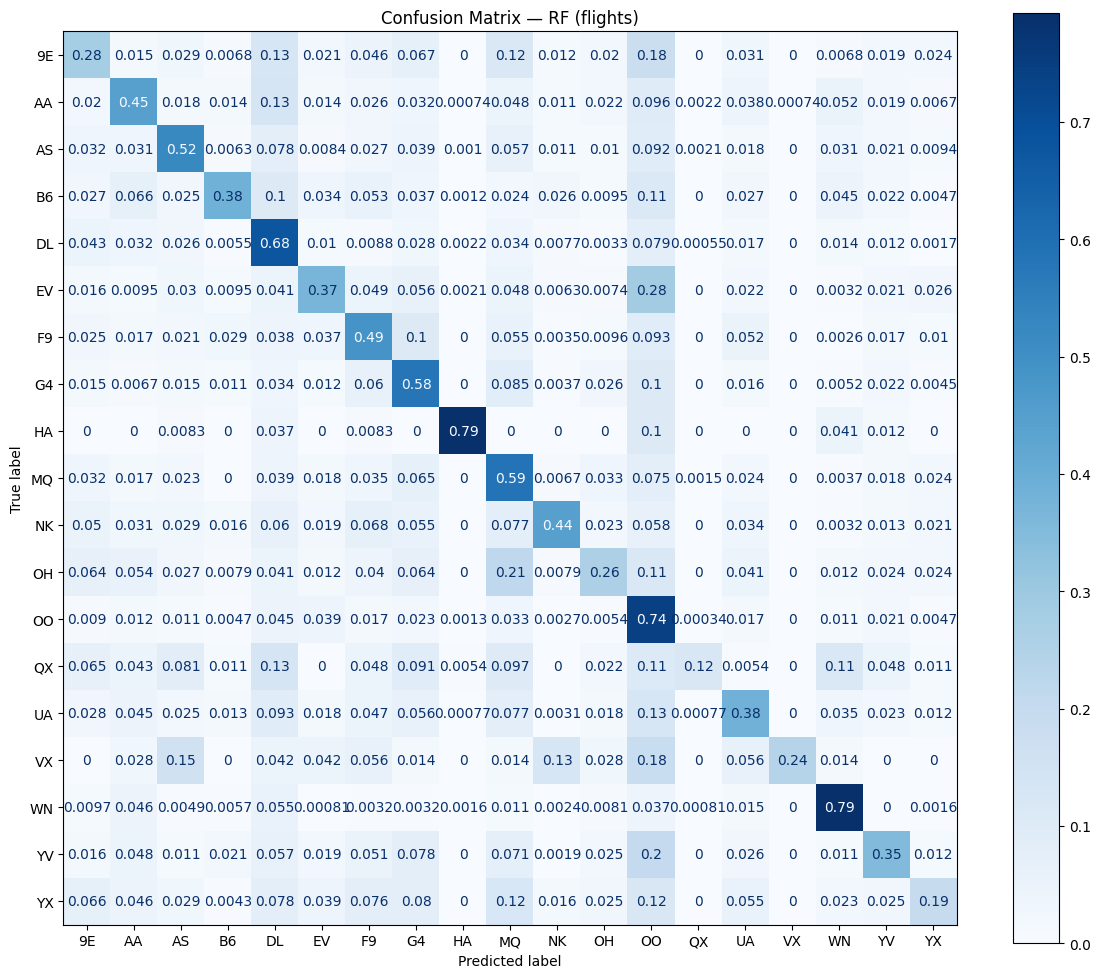

Accuracy: 0.5125598381286088

Classification report:
               precision    recall  f1-score   support

          9E       0.36      0.28      0.32      1034
          AA       0.52      0.45      0.48      1344
          AS       0.55      0.52      0.54       957
          B6       0.64      0.38      0.48       845
          DL       0.50      0.68      0.58      1809
          EV       0.47      0.37      0.41       945
          F9       0.45      0.49      0.47      1144
          G4       0.46      0.58      0.52      1336
          HA       0.92      0.79      0.85       241
          MQ       0.40      0.59      0.47      1351
          NK       0.65      0.44      0.53       620
          OH       0.44      0.26      0.32       881
          OO       0.53      0.74      0.62      2984
          QX       0.67      0.12      0.20       186
          UA       0.50      0.38      0.43      1303
          VX       0.94      0.24      0.38        71
          WN       0.74    

In [10]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_model_flights = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=150,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model_flights.fit(X_flights_train_raw, y_flights_train)
y_pred = rf_model_flights.predict(X_flights_test_raw)

print("Accuracy:", accuracy_score(y_flights_test, y_pred))
print("\nClassification report:\n", classification_report(y_flights_test, y_pred))

fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(y_flights_test, y_pred, normalize="true", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix — RF (flights)")
plt.tight_layout(); plt.show()

print("Accuracy:", accuracy_score(y_flights_test, y_pred))
print("\nClassification report:\n", classification_report(y_flights_test, y_pred))

За результатами навчання моделі Random Forest, отримано точність 0.51 (51%), що є суттєвим покращенням порівняно з попередньою моделлю Decision Tree (32%). Це свідчить про значно вищу узагальнювальну здатність ансамблевого підходу, який зменшує ризик перенавчання та краще враховує структуру високорозмірних даних.

Показники macro F1 = 0.48 та weighted F1 = 0.50 демонструють збалансованіше співвідношення між точністю та повнотою прогнозів, особливо для класів із великою кількістю спостережень. Аналіз матриці плутанини показує, що модель успішно класифікує більшість основних авіакомпаній (DL, WN, OO, HA, G4), досягаючи рівня recall від 0.58 до 0.79. Водночас для малочисельних класів (QX, VX, YX) точність залишається обмеженою, що вказує на вплив дисбалансу вибірки.

# Висновки

Dataset 1 — Microsoft Security Incident Prediction

Після попередньої обробки даних (усунення пропусків, видалення малозаповнених ознак та нормалізації) модель Decision Tree досягла точності ≈ 0.87 і середнього значення F1_macro ≈ 0.79. Незважаючи на загалом високу точність, результати показали помітну плутанину між класами Malicious та NoThreatsFound, що свідчить про вплив дисбалансу вибірки.
Використання Random Forest покращило результати (accuracy ≈ 0.88, F1_macro ≈ 0.80) завдяки усередненню помилок окремих дерев і підвищенню стійкості моделі. Однак часткова плутанина між схожими класами збереглася. Отже, ансамблевий підхід продемонстрував кращу узагальнювальну здатність, але потребує подальшого балансування даних для підвищення точності мінорних класів.

Dataset 2 — API Access Behaviour Anomaly Dataset

Моделі Decision Tree та Random Forest продемонстрували ідеальні результати (accuracy = 1.00, F1_macro = 1.00) як на навчальних, так і на тестових даних. Така повна відповідність передбачень реальним міткам може вказувати на надто просту структуру задачі або на потенційний витік даних (data leakage).
Для підтвердження достовірності результатів доцільно провести перевірку на дублікати між train/test вибірками, а також протестувати моделі на незалежному наборі даних. Незважаючи на формально ідеальні метрики, отримані показники потребують додаткової перевірки коректності розподілу даних.

Dataset 3 — US Flight Delay Dataset

Цей набір даних містив понад 100 000 записів та 19 класів (авіакомпаній). Початкова модель Decision Tree показала низьку точність ≈ 0.32 і F1_macro ≈ 0.26, що свідчить про складність багатокласової класифікації при значному дисбалансі класів.
Використання Random Forest підвищило якість до accuracy ≈ 0.51, F1_macro ≈ 0.48, завдяки кращому узагальненню ансамблю. Модель більш впевнено класифікувала основні класи (DL, WN, OO, HA, G4), але залишалася малоефективною для рідкісних (QX, VX, YX). Це підкреслює потребу у застосуванні методів балансування (oversampling, class weights) та глибшої оптимізації параметрів.
